In [1]:
#|include: false
from IPython.display import Markdown as md

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import random as rn


# [DRAFT]
# A (not that) funny joke

Once upon a time, in the last century, a teacher of mine was complaining about the latest increase of the gasoline price. The old man was finishing his complains with a misogynic joke about his wife:

:boar:: *The gas price went up a gain. It doesn't matter for my wife, though. She always refuels for 10 bugs. Hahaha.*

Besides he shouldn't have talked like this about his wife, the idea of always spending the same amount of money on the gas station to avoid price raises seamed to be pretty funny. I since used a variation of this da(e)d joke every now and then, like *"I always refuel for 10 bugs, lol."* and you certainly have heard this joke often, too.

:fast_forward: Now, 25 years later ... 

I was driving with my wife to a party and she realized that I've filled up the car after shopping in the afternoon. She was very happy that she wouldn't need to stop at the gas station during the upcoming week. I told here proudly that the price for gas was low and I saved 30 ct per liter compared to four weeks ago. Once again I quietly had to think about this bad joke. Suddently, when I was just about to grin, I was struck by a though: *"Is it possible that the person, who is always refueling for exactly 10 bugs, is right and the others, that are laughing about this strategy, are actually the idiots?!"*.

This thought come up because the night before I've watched some YouTube videos about investment strategies. One example[^1] was to follow a saving plan and put the same amount of money into funds on a regulare basis, say 100 Euro every month. In the interview a question come up, what would happen when the market goes down and the portfolio looses value. The answer was pretty simple: *If you invest regularely then you hit the market when it goes up the one day and when it goes down the other day.* So the volatility doesn't matter that much on the long run. This intuativally made sense. The constant investing smoothes out the volatility. Since you can't predict the stock prices, it's hard to **time** the market, hence predicting when buying is cheap over a short period of time.

So, I left the party with two thoughts to investogate:

- 1. What is a suitable refueling strategy?
- 2. Is my intuition on about the constant fund investment reasonable?

Let's start with the car.

# Refueling Strategies

These are the average prices for Fuel in Germany from January 2021 to November 2022 from @destatis_2022.

In [2]:
#|include: false

gas_data = pd.read_excel('MTS_K_Kraftstoffpreise.xlsx', 'Daten')
gas_data.columns = ['Date', 'E5', 'E10','Diesel']
gas_data = gas_data#[gas_data.Date.dt.year==2021]
gas_data = gas_data.melt(id_vars='Date',var_name='Fuel',value_name='Price')

gas_data

,Date,Fuel,Price
0,2021-01-01,E5,1.37
1,2021-01-02,E5,1.38
2,2021-01-03,E5,1.38
3,2021-01-04,E5,1.38
4,2021-01-05,E5,1.38
...,...,...,...
2146,2022-12-14,Diesel,1.79
2147,2022-12-15,Diesel,1.80
2148,2022-12-16,Diesel,1.81
2149,2022-12-17,Diesel,1.82


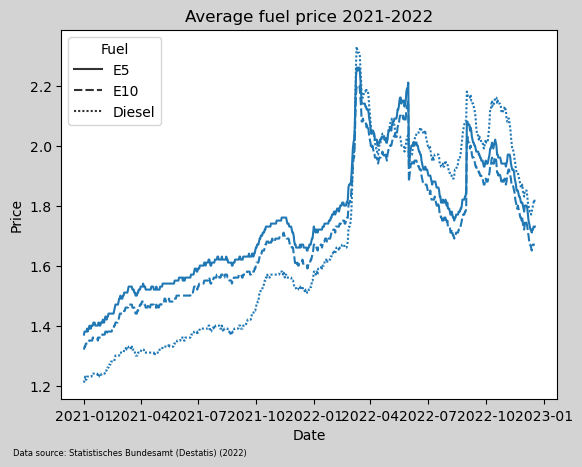

In [15]:
#|echo: false

gas_data = pd.read_excel('MTS_K_Kraftstoffpreise.xlsx', 'Daten')
gas_data.columns = ['Date', 'E5', 'E10','Diesel']
gas_data = gas_data#[gas_data.Date.dt.year==2021]
gas_data = gas_data.melt(id_vars='Date',var_name='Fuel',value_name='Price')

fig = plt.figure()
fig.patch.set_facecolor('lightgray')

sns.lineplot(x="Date", y="Price",
             style="Fuel", #style="event",
             data=gas_data)

plt.title('Average fuel price 2021-2022')
plt.annotate('Data source: Statistisches Bundesamt (Destatis) (2022)', (0,0), (-35,-35), fontsize=6, 
             xycoords='axes fraction', textcoords='offset points', va='top')
plt.show()

2021 was a pretty normal year, fuel prices slightly increased, with some noisy up and downs. 2022 was really crazy with high raises and steep dives of the fuel price.

Since our car is using Diesel I'll do the following simulations for Diesel. Our car is driving appoximatally *12,000 km* per year and has a consumption of *6.4 liter per 100 km*. We assume we drive the same distance with the same consumption on everday of the year.

::: {.column-margin}
12,000 km/year

0.064 l/km

2.104 l/day
:::


We'll compare three different refueling strategies:

- **Strategy 1: Fixed payment:** 

    We refuel for exactly *€ 45* everytime the tank has *less than 10 liters*. The tank has a capacity of 55 liters, hence fuel for € 45 fits when we refuel. This referse to the "joke" strategy.
    
- **Strategy 2: Regularly, fixed amount of fuel:** 

    Since we are comsuming the same amount of fuel everyday, we refill *every 15 days* the same amount of fuel regardless of the price.
    
- **Strategy 3: Fill on lowest price:**

    We have a magic crystal ball and know every price in advance. So we (partially) refuel always on the *lowest price* in a 20 day window. 
    


In [19]:
#|include: false

def gas_simu(year = 2021):
    days_hd = 15
    window=20
    liter_threshold=10
    const_amount = 45
    consumption = 6.4*120/365 # liter per day

    gas_data = pd.read_excel('MTS_K_Kraftstoffpreise.xlsx', 'Daten')
    gas_data.columns = ['Date', 'E5', 'E10','Diesel']
    gas_data = gas_data[gas_data.Date.dt.year==year].reset_index(drop=True)

    gas_data[f'liter_per_{const_amount}eur'] = const_amount/gas_data.Diesel
    gas_data['cons_roll'] = consumption * (1+gas_data.index)

    gas_data.loc[0,'Liter same amount']=liter_threshold+gas_data.loc[0,f'liter_per_{const_amount}eur']-consumption
    gas_data.loc[0,f'€ {const_amount} everytime'] = gas_data.loc[0,'Diesel']
    for i in gas_data.index.values[1:]:
        gas_data.loc[i,'Liter same amount'] = gas_data.loc[i-1,'Liter same amount'] + (gas_data.loc[i,f'liter_per_{const_amount}eur'] if gas_data.loc[i-1,'Liter same amount']<=liter_threshold else 0)-consumption
        gas_data.loc[i,f'€ {const_amount} everytime'] = gas_data.loc[i,'Diesel'] if gas_data.loc[i-1,'Liter same amount']<=liter_threshold else None
    gas_data[f'€ {const_amount} everytime'] = gas_data[f'€ {const_amount} everytime'].fillna(method="ffill")

    gas_data.loc[gas_data.index%days_hd==0, 'Liter cont.'] = 35
    gas_data.loc[gas_data.index%days_hd==0, f'every {days_hd} days'] = gas_data.Diesel
    gas_data[f'every {days_hd} days'] = gas_data[f'every {days_hd} days'].fillna(method="ffill")
    gas_data.loc[gas_data.index%days_hd==0, 'Liter fill'] = 35
    for i in range(21):
        gas_data[f'rm_{i}']=gas_data.Diesel.shift(i)
    gas_data[f'best price within {window} days'] = gas_data[[f'rm_{i}' for i in range(21)]].fillna(99999).min(axis=1)
    gas_data['Refuel worst 10'] = gas_data[[f'rm_{i}' for i in range(21)]].fillna(0).max(axis=1)
    gas_data['Refuel vola 10'] = gas_data[[f'rm_{i}' for i in range(21)]].std(axis=1)

    gas_data_melt = gas_data[['Date',f'€ {const_amount} everytime',f'every {days_hd} days',f'best price within {window} days']].melt(id_vars=['Date'],var_name='Refuel Strategies',value_name='Price')
    
    avg_price_fixed_pay, avg_price_fixed_fuel, avg_price_cheapest = gas_data[['Date',f'€ {const_amount} everytime',f'every {days_hd} days',f'best price within {window} days']].mean().values

    stops=gas_data[~(gas_data[f'€ {const_amount} everytime']==gas_data[f'€ {const_amount} everytime'].shift(1))].reset_index()[['index']]
    stops_fixed_pay= (((stops['index']-stops['index'].shift(1))//20).sum()+stops.shape[0])

    stops=gas_data[~(gas_data[f'every {days_hd} days']==gas_data[f'every {days_hd} days'].shift(1))].reset_index()[['index']]
    stops_fixed_fuel = (((stops['index']-stops['index'].shift(1))//20).sum()+stops.shape[0])

    stops=gas_data[~(gas_data[f'best price within {window} days']==gas_data[f'best price within {window} days'].shift(1))].reset_index()[['index']]
    stops_cheapest= (((stops['index']-stops['index'].shift(1))//20).sum()+stops.shape[0])
    
    return gas_data, gas_data_melt, avg_price_fixed_pay, avg_price_fixed_fuel, avg_price_cheapest, stops_fixed_pay, stops_fixed_fuel, stops_cheapest

In [20]:
#|include: false

gas_data, gas_data_melt, avg_price_fixed_pay, avg_price_fixed_fuel, avg_price_cheapest, stops_fixed_pay, stops_fixed_fuel, stops_cheapest = gas_simu(year = 2021)


/tmp/ipykernel_83/4065910052.py:36: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  avg_price_fixed_pay, avg_price_fixed_fuel, avg_price_cheapest = gas_data[['Date',f'€ {const_amount} everytime',f'every {days_hd} days',f'best price within {window} days']].mean().values


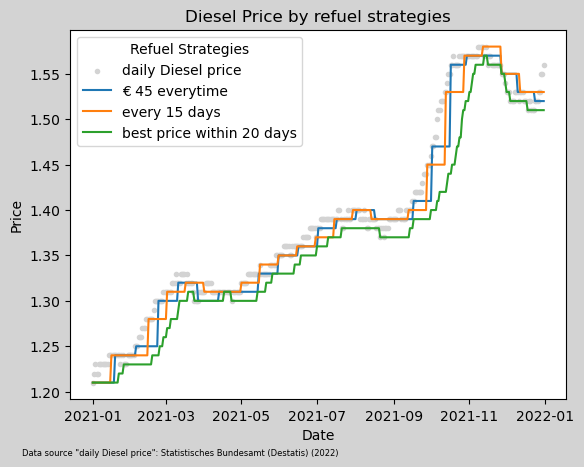

In [22]:
#|echo: false

fig = plt.figure()
fig.patch.set_facecolor('lightgray')

plt.scatter(gas_data.Date,gas_data.Diesel, label = 'daily Diesel price', marker = '.', color='lightgray')

sns.lineplot(x="Date", y="Price",
             hue="Refuel Strategies",
             data=gas_data_melt)

plt.title('Diesel Price by refuel strategies')
plt.annotate('Data source "daily Diesel price": Statistisches Bundesamt (Destatis) (2022)', (0,0), (-35,-35), fontsize=6, 
             xycoords='axes fraction', textcoords='offset points', va='top')

plt.show()

The chart shows the price of the consumed fuel for everyday for each of the strategie. For example, when refuel with strategy 2 on January 16th for € 1.24/l you'll consume Diesel worth € 1.24/l for the next 15 days.

Obviously, strategy 3 always has the lowest price. The average price and the yearly consumtion for the three strategies are:

In [73]:
#|echo: false

md(f'''
- Strategy 1: € {avg_price_fixed_pay: ,.4f}/l => € {avg_price_fixed_pay*6.4*120: ,.0f}/year
- Strategy 2: € {avg_price_fixed_fuel: ,.4f}/l => € {avg_price_fixed_fuel*6.4*120: ,.0f}/year
- Strategy 3: € {avg_price_cheapest: ,.4f}/l => € {avg_price_cheapest*6.4*120: ,.0f}/year

Which leads to a total saving of € {(avg_price_fixed_pay-avg_price_cheapest)*6.4*120: ,.2f}/year if I could predict the cheapest price for the next 20 days 
compared to strategy 1 and € {(avg_price_fixed_fuel-avg_price_cheapest)*6.4*120: ,.2f}/year compared to strategy 2.

Doesn't sound much, but it's still a saving of approx. {(avg_price_fixed_pay-avg_price_cheapest)/avg_price_fixed_pay*100: ,.2f}% or 
additional fuel for a {12000*(avg_price_fixed_pay-avg_price_cheapest)/avg_price_fixed_pay: ,.0f} km drive.

When we look a bit closer at the chart, we see that the best strategy line is very fine grained and the other two strategies are more bumpy 
with long flat plateauxs. This indicates, that to accomplishe the best price strategy, we need to hit the gas station more often.
Here are the number of pit stops needed for the three strategies:

- Strategy 1: {stops_fixed_pay: ,.0f} stops
- Strategy 2: {stops_fixed_fuel: ,.0f} stops
- Strategy 3: {stops_cheapest: ,.0f} stops

This is a total different picture. To achieve a saving of € {(avg_price_fixed_pay-avg_price_cheapest)*6.4*120: ,.2f}/year 
I would not only need the magic chrystal ball, but I would also need to make {stops_cheapest-stops_fixed_pay:,.0f} more stops at the gas station per year.
Let's say one stop takes 10 minutes (waiting in line, refueling, paying), that's an additional {(stops_cheapest-stops_fixed_pay)*10/60:,.2f} hours per year 
spening at the gas station.

During this additional {(stops_cheapest-stops_fixed_pay)*10/60:,.2f} hours I can walk with my daughter at 4km/h her daily 2x2km march to kindergarden 
{(stops_cheapest-stops_fixed_pay)*10/60 * 4 / 4: 0,.1f} times. Which is {(stops_cheapest-stops_fixed_pay)*10/60 * 4: 0,.1f} km or a Diesel saving of 
€ {(stops_cheapest-stops_fixed_pay)*10/60 * 4*avg_price_fixed_pay*6.4/100: 0,.1f} in strategy 1 and 
if I take insurance, taxes, regular maintanance and car depreciation into account it's a saving of € {(stops_cheapest-stops_fixed_pay)*10/60 * 4*0.36: 0,.1f} (with 0.36 ct/km in 2021).
''')


- Strategy 1: €  1.3812/l => €  1,061/year
- Strategy 2: €  1.3829/l => €  1,062/year
- Strategy 3: €  1.3628/l => €  1,047/year

Which leads to a total saving of €  14.10/year if I could predict the cheapest price for the next 20 days 
compared to strategy 1 and €  15.38/year compared to strategy 2.

Doesn't sound much, but it's still a saving of approx.  1.33% or 
additional fuel for a  159 km drive.

When we look a bit closer at the chart, we see that the best strategy line is very fine grained and the other two strategies are more bumpy 
with long flat plateauxs. This indicates, that to accomplishe the best price strategy, we need to hit the gas station more often.
Here are the number of pit stops needed for the three strategies:

- Strategy 1:  24 stops
- Strategy 2:  24 stops
- Strategy 3:  54 stops

This is a total different picture. To achieve a saving of €  14.10/year 
I would not only need the magic chrystal ball, but I would also need to make 30 more stops at the gas station per year.
Let's say one stop takes 10 minutes (waiting in line, refueling, paying), that's an additional 5.00 hours per year 
spening at the gas station.

During this additional 5.00 hours I can walk with my daughter at 4km/h her daily 2x2km march to kindergarden 
 5.0 times. Which is  20.0 km or a Diesel saving of 
€  1.8 in strategy 1 and 
if I take insurance, taxes, regular maintanance and car depreciation into account it's a saving of €  7.2 (with 0.36 ct/km in 2021).


Now, that we have a picture of 2021 and can decide on personal preference and clairvoyant abilities to abondomn or to go for Strategy 3, we still don't have a clear picture of Strategy 1 and 2. In 2021 they look pretty similare with the given parameters. But it's also clear, that you would have to make more gasstation stops, if we either lower the fixed paying amount of strategy 1 or if we shorten the refilling interval of strategy 2.

Let's see what happens when the prices go crazy like in 2022.



In [74]:
#|include: false

gas_data, gas_data_melt, avg_price_fixed_pay, avg_price_fixed_fuel, avg_price_cheapest, stops_fixed_pay, stops_fixed_fuel, stops_cheapest = gas_simu(year = 2022)


/tmp/ipykernel_83/4065910052.py:36: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  avg_price_fixed_pay, avg_price_fixed_fuel, avg_price_cheapest = gas_data[['Date',f'€ {const_amount} everytime',f'every {days_hd} days',f'best price within {window} days']].mean().values


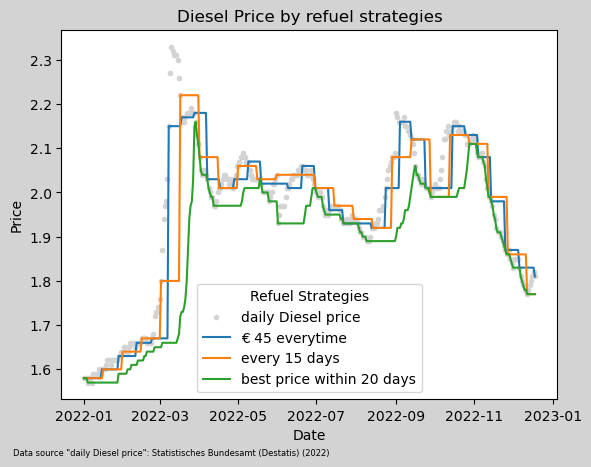

In [75]:
#|echo: false

fig = plt.figure()
fig.patch.set_facecolor('lightgray')

plt.scatter(gas_data.Date,gas_data.Diesel, label = 'daily Diesel price', marker = '.', color='lightgray')

sns.lineplot(x="Date", y="Price",
             hue="Refuel Strategies",
             data=gas_data_melt)

plt.title('Diesel Price by refuel strategies')
plt.annotate('Data source "daily Diesel price": Statistisches Bundesamt (Destatis) (2022)', (0,0), (-35,-35), fontsize=6, 
             xycoords='axes fraction', textcoords='offset points', va='top')

plt.show()

In [146]:
#|echo: false

md(f'''
These are the numbers for 2022:

- Strategy 1: € {avg_price_fixed_pay: ,.4f}/l => € {avg_price_fixed_pay*6.4*120: ,.0f}/year => {stops_fixed_pay: ,.0f} stops
- Strategy 2: € {avg_price_fixed_fuel: ,.4f}/l => € {avg_price_fixed_fuel*6.4*120: ,.0f}/year => {stops_fixed_fuel: ,.0f} stops
- Strategy 3: € {avg_price_cheapest: ,.4f}/l => € {avg_price_cheapest*6.4*120: ,.0f}/year => {stops_cheapest: ,.0f} stops

Which result in savings and additinal hours spent at the gas station like this:
''')


These are the numbers for 2022:

- Strategy 1: €  1.9517/l => €  1,499/year =>  33 stops
- Strategy 2: €  1.9481/l => €  1,496/year =>  24 stops
- Strategy 3: €  1.8818/l => €  1,445/year =>  111 stops

Which result in savings and additinal hours spent at the gas station like this:


In [145]:
#|include: false

sav_mx = np.array([avg_price_fixed_pay,avg_price_fixed_fuel,avg_price_cheapest])*6.4*120
sav_mx=-np.subtract.outer(sav_mx,sav_mx)

stops_mx = np.array([stops_fixed_pay,stops_fixed_fuel,stops_cheapest])*10/60
stops_mx=np.subtract.outer(stops_mx,stops_mx)

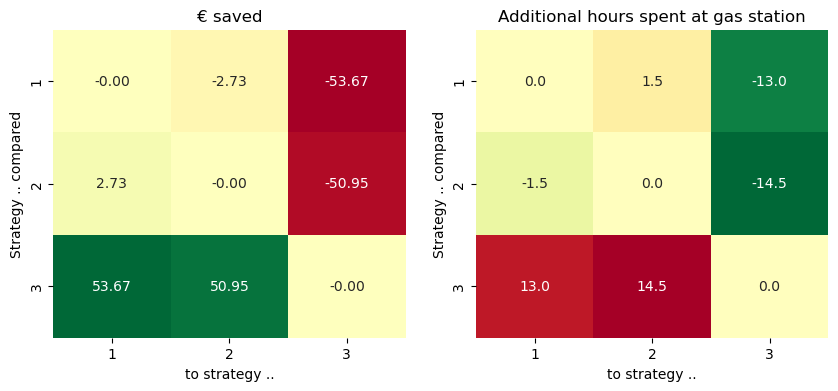

In [144]:
#|echo: false

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))

sns.heatmap(sav_mx, cmap='RdYlGn', annot=True, fmt=".2f", cbar=False, ax=ax1)
ax1.set(xlabel="to strategy ..", ylabel="Strategy .. compared", 
       xticklabels=[1,2,3], yticklabels=[1,2,3], 
       title = '€ saved')

sns.heatmap(stops_mx, cmap='RdYlGn_r', annot=True, fmt=".1f", cbar=False, ax=ax2)
ax2.set(xlabel="to strategy ..", ylabel="Strategy .. compared", 
       xticklabels=[1,2,3], yticklabels=[1,2,3], 
       title = 'Additional hours spent at gas station')

plt.show()

In 2022 strategy 2 is supperior to strategy 1. The higher number of gas station stops results from not adjusting the fixed payment amount to the higher prices.

# Conclusion
The "joke" is not funny anymore. A) no one can predict the prices precisly B) waiting at the gas station for a € 3-4/hours "salary" doesn't make sense. 
After comparing the three strategies with the data from 2021 and 2022 I personally prefer strategy number 2.

:::{.callout-tip}
## Life hacks
- Default to not taking the car, instead
    - commute by walking, train, bus, bike, stay at home, share rides,
    - go shopping by walking, train, bus, bike, shop online,
    - go to Kindergarden/School by walking, train, bus, bike.
- Don't bother about the fuel price.
- Refuel the entire tank.
- Refuel early if you fear traffic jams in winter. A standing heating is still very thirsty. 
:::

# Fictional investment strategy

:::{.callout-warning}
## Disclaimer 
This blog post is not a financial advice! This is a toy example. This blog post is full of unrealistic assumption. All numbers are made up. Reach out to a professional financial advisor you trust, if you need financial advise. And most important, take a spreadsheet and do the math yourself with your numbers and your assumptions.
:::


In [147]:
#|include: false

timeslots = 200
investment = timeslots * 100
t_max=-1

x = np.linspace(1, timeslots, timeslots)
trend = 1.5
vola = np.random.normal(0, 0.15, timeslots)

y = 10 + x * trend/timeslots + vola


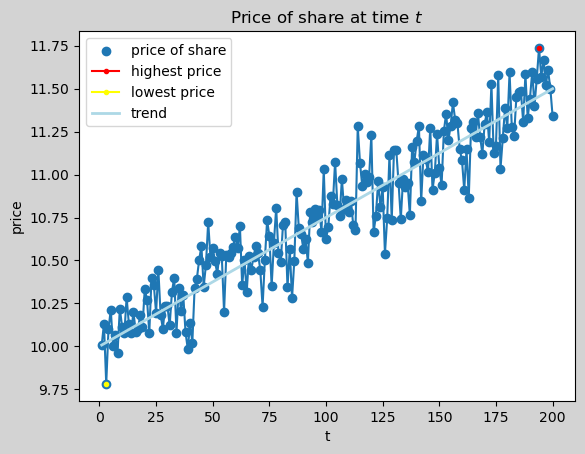

In [148]:
#|echo: false

fig = plt.figure()
ax=plt.axes()
fig.patch.set_facecolor('lightgray')
#fig.patch.set_alpha(0.2)
#ax.set(facecolor = "lightgray")

plt.scatter(x, y, label = 'price of share')
plt.plot(x, y)
#plt.plot(x[vola.argmax()], y[vola.argmax()], marker='o', markersize=3, color="red")
#plt.plot(x[vola.argmin()], y[vola.argmin()], marker='o', markersize=3, color="yellow")
plt.plot(x[y.argmax()], y[y.argmax()], marker='o', markersize=3, color="red", label = 'highest price')
plt.plot(x[y.argmin()], y[y.argmin()], marker='o', markersize=3, color="yellow", label = 'lowest price')
plt.plot(x, 10+x*trend/timeslots, label = 'trend',linewidth=2, color = 'lightblue')

plt.ylabel('price')
plt.xlabel('t')
plt.title('Price of share at time $t$')
plt.legend()

plt.show()

In [149]:
#|echo: false

best_return = y.max()/y.min()-1

md(f" With an investment of € {investment:,.0f} at the lowest price at t={y.argmin()+1} and selling at the highest price at t={y.argmax()+1} the return is {best_return*100:,.2f}% and yields € {investment*best_return:,.0f}.")

 With an investment of € 20,000 at the lowest price at t=3 and selling at the highest price at t=194 the return is 20.00% and yields € 4,001.

## Setting up the scene

Since we don't know when the price will be lowest and highest, we consider two investment strategies and see how they play out.

### Two investment strategies
#### One-time investment

#### Continuous investment

### Objectives

#### Accumulate most shares
#### Value at end of period

In [150]:
#| include: false

cum_amount = (investment/x)*(1/y).cumsum()

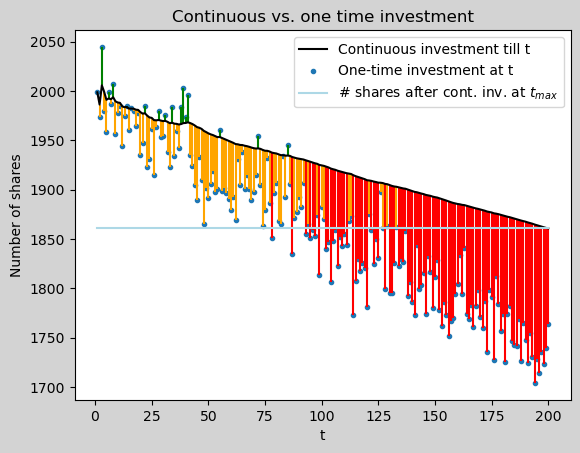

In [151]:
#|echo: false

fig = plt.figure()
fig.patch.set_facecolor('lightgray')

plt.errorbar(x, cum_amount, [(cum_amount-investment/y)*(cum_amount<investment/y),
                                                  -(cum_amount-investment/y)*(cum_amount>investment/y)],
            fmt = 'none',
            ecolor = np.vectorize({0:'r', 1:'orange', 2: 'green'}.get)(((cum_amount)<(investment/y))*1+(cum_amount[t_max]<(investment/y))*1))

plt.plot(x, cum_amount, label = 'Continuous investment till t', color = 'black')
plt.scatter(x,investment/y, label = 'One-time investment at t', marker = '.')
plt.plot(x, np.ones(timeslots)*cum_amount[t_max], label = '# shares after cont. inv. at $t_{max}$', color = 'lightblue')

plt.ylabel('Number of shares')
plt.xlabel('t')
plt.title('Continuous vs. one time investment')
plt.legend()

plt.show()

::: {.column-margin}
<span style="color:blue">**Blue dots:**</span>
$$
onetime(t) = \frac{cash}{price_t}
$$

**Black line:**
$$
\begin{aligned}
cont(t) &= \sum^t_i{ \frac{cash/t}{price_i}} \\
        &= \frac{cash}{t} \sum^t_i{ \frac{1}{price_i}}
\end{aligned}
$$

<span style="color:lightblue">**Light blue line:**</span>
$$
contmax(t) = cont(n)
$$
:::

The <span style="color:blue">**blue dots**</span> mark the number of shares that can perchased when the entire money is invested at once at the given time *t*. 

The **black line** indicates the number of shares that can be buyed when the entire investent is equally spread from *t=0* up to a given *t*.

The <span style="color:lightblue">**light blue line**</span> highlights the number of shares of the last entry of the black line, hence the cash is equally invested over the entire period of time.

A <span style="color:green">**green line**</span> marks the one-time investment that always reach a higher number of shares compared to the continuous investment, regardless of the duration.

A <span style="color:red">**red lines**</span> indicates the one-time investment that can never reach the number of shares of the continuous investment at any time in $0<t<=n$.

An <span style="color:orange">**orange line**</span> marks the one-time investment that has fewer number of shares as the continous investment at the given time, if the entire cash has been equally distrubted to the given *t*. However, if the continous investments are spread for a wider period of time, the one-time investment will be superior to the continuous investment at a later point in time.

With our dummy data the strategie to put a big investment at once is good if the investment can stay invested untouched for a long period of time. If the money needs to shortly be withdrawn from the investment the continous strategie is preferable, regarding number of shares. The tipping point between the strategies is close to $t/2$.

Let's see, next, how the amount of shares result in value at $t=n$, 

In [152]:
#|include: false

cum_cash = investment-x*(investment/timeslots)
cum_inv = ((investment/timeslots)*(1/y).cumsum())*y[t_max]
cum_value = cum_inv + cum_cash

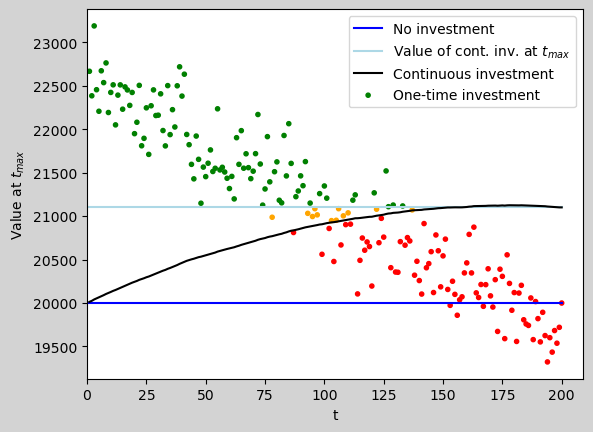

In [153]:
#|echo: false

fig = plt.figure()
fig.patch.set_facecolor('lightgray')

plt.plot(x, np.ones(timeslots)*investment, label = 'No investment', color = 'blue')
plt.plot(x, np.ones(timeslots)*cum_value[t_max], label = 'Value of cont. inv. at $t_{max}$', color = 'lightblue')
plt.plot(x, cum_value, label = 'Continuous investment', color = 'black')
#plt.plot(x, y[t_max]*investment/y, label = 'One-time investment',color='gray')
plt.scatter(x, y[t_max]*investment/y, label = 'One-time investment', marker='.',
           color=np.vectorize({0:'r', 1:'orange', 2: 'green'}.get)(((y[t_max]*investment/y)>(cum_value[t_max]))*1+(((y[t_max]*investment/y)>(cum_value))*1)))

plt.ylabel('Value at $t_{max}$')
plt.xlabel('t')
plt.xlim(0,timeslots+10+t_max)
plt.legend()

plt.show()

::: {.column-margin}
<span style="color:blue">**Blue line:**</span>
$$
cash(t)=cash
$$

**Black line:**
$$
\begin{aligned}
cont(t) &= inv_{acc_t}+cash_{remaining_t} \\ 
        &= p_n*\frac{cash}{n}\sum^t_i{\frac{1}{p_i}} + cash*(1-\frac{t}{n})
\end{aligned}
$$

<span style="color:lightblue">**Light blue line:**</span>
$$
contmax(t) = cont(n)
$$

**Dots:**
$$
onetime(t) = p_n*\frac{cash}{p_t}
$$
:::

The <span style="color:blue">**blue line**</span> is our net worth if we don't invest and keep cash for the entire period of time.

The **black line** inducates the net worth in a continuous investment strategie. At time *t* the number of share that are accumulated sofare are multiplied by the price at the end of the time periode. Also, the remaing cash at time *t* is added to the investment value.

The <span style="color:lightblue">**light blue**</span> line highlights the net worth of the continous investment at the end of the periode of time.

The **dots** indicate the value of a one-time purchase at the end of the periode of time.

A <span style="color:red">**red dot**</span> one-time investment is always worse than the continuous strategie.

A <span style="color:green">**green dot**</span> one-time investment results in a higher net value at the end of the periode compared to the continous investment.

An <span style="color:orange">**orange dot**</span> one-time investment is superior to the continous investment for a certain periode of time. But if the continuous strategie will go on till the end, the orange dot will result in a smaller net worth.

The <span style="color:lightblue">**light blue**</span> and **black line** is highly volatile, since it depend only on one price, the last one. If the period gets shortend the area of the <span style="color:green">**green**</span>, <span style="color:orange">**orange**</span> and <span style="color:red">**red dots**</span> will change accordingly. To reduce volatility the selling can be spread over many periodes, like the continuous strategy to accumulate shares. 

Again, the startegy to invest all at once is preferable, if the investments won't be sold for a long time. If the investment needs to be soled at any time a continous strategie is preferable with this dummy data.

[^1]: I've forgot which video it was, maybe something with JL Collins.